# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP. HCM
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU
<br/>

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY DỰ ĐOÁN GIÁ NÔNG SẢN

<br/>

<p>Họ và tên Sinh viên 1 : Huỳnh Hạo Nhị MSSV 1: 20133006 <p>
<br/>
Họ và tên Sinh viên 2 : Võ Hoài Thương MSSV 2: 20133012

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV

from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Dữ liệu

In [2]:
RICE_QUANTITY_URI = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Lua/gia_lua_nang_xuat.csv"


## VAR MODEL

Mô hình VAR (vector autoregressive models) được sử dụng cho chuỗi thời gian đa biến. Cấu trúc của nó là mỗi biến là một hàm tuyến tính của các lag của chính nó và các lag của các biến khác

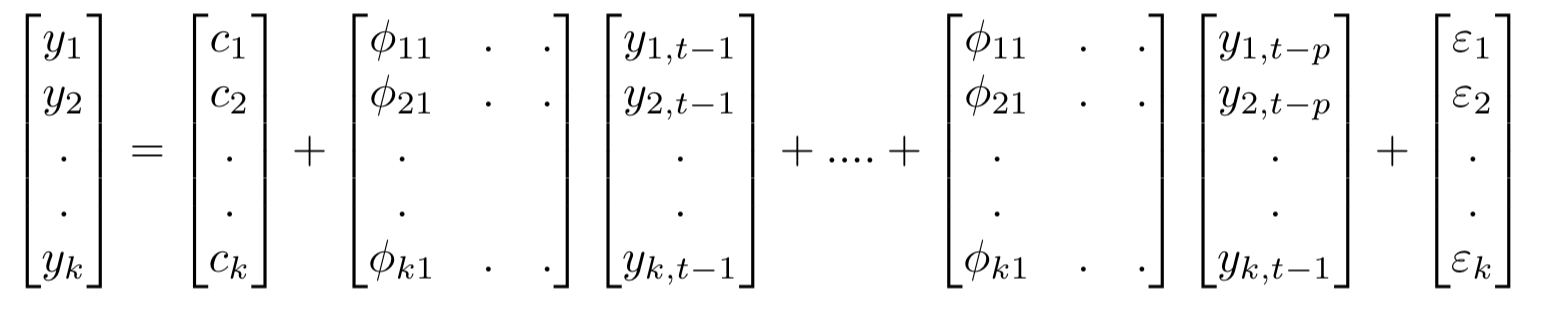

In [3]:
df = pd.read_csv(RICE_QUANTITY_URI)

In [4]:
df.set_index('date', inplace=True)

In [5]:
df.head()

,Unnamed: 0,price,tavg,tmin,tmax,prcp,wdir,wspd,pres,area,productivity,quantity
date,,,,,,,,,,,,
2010-01-05,0,8250,26.888889,23.277778,33.222222,0.909,117.0,7.2,1011.0,234.2,73.0,1708.9
2010-01-07,1,8250,26.722222,21.611111,34.000000,0.909,42.0,5.4,1011.0,234.2,73.0,1708.9
2010-01-11,2,8250,26.388889,23.000000,31.611111,0.909,42.0,5.4,1011.0,234.2,73.0,1708.9
2010-01-12,3,8250,25.777778,23.000000,32.000000,0.909,42.0,6.2,1011.0,234.2,73.0,1708.9
2010-01-13,4,8250,25.777778,21.000000,32.388889,0.909,42.0,4.5,1011.0,234.2,73.0,1708.9


<Axes: >

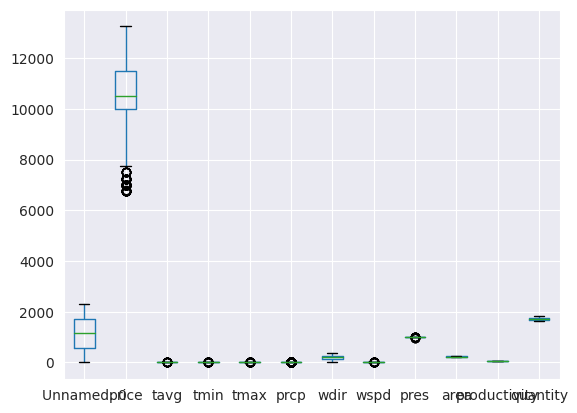

In [6]:
df.boxplot()

In [7]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df.at[df.index[0], 'price'] = min(max(df.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df.index[previous_date_index]
        previous_value = df.loc[previous_date, 'price']
        df.at[index, 'price'] = previous_value

Số lượng outlier: 127


<Axes: >

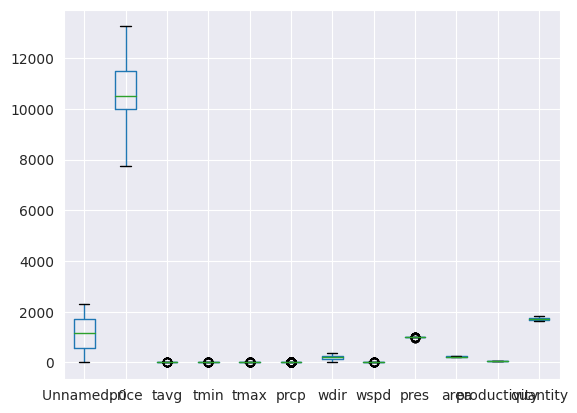

In [8]:
df.boxplot()

In [9]:
df = df.dropna()

In [10]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,Unnamed: 0,price,tavg,tmin,tmax,prcp,wdir,wspd,pres,area,productivity,quantity
Unnamed: 0,1.000000,0.709175,0.268578,0.320828,-0.024726,-0.290490,0.010370,-0.053715,-0.435825,-0.663669,-0.111315,-0.374795
price,0.709175,1.000000,0.121355,0.137058,-0.039542,-0.277434,0.066501,-0.045298,-0.227452,-0.581519,0.173036,-0.088887
tavg,0.268578,0.121355,1.000000,0.757224,0.772826,-0.191030,-0.008995,0.254446,-0.153324,-0.118950,-0.116321,-0.150655
tmin,0.320828,0.137058,0.757224,1.000000,0.472309,-0.216604,0.125172,0.297213,-0.270906,-0.131664,-0.131303,-0.170009
tmax,-0.024726,-0.039542,0.772826,0.472309,1.000000,-0.039484,-0.088448,0.183722,0.069760,-0.010494,-0.035935,-0.034372
prcp,-0.290490,-0.277434,-0.191030,-0.216604,-0.039484,1.000000,-0.095522,-0.066680,0.105374,0.022204,0.063918,0.065814
wdir,0.010370,0.066501,-0.008995,0.125172,-0.088448,-0.095522,1.000000,0.064865,-0.243136,0.014170,-0.104926,-0.087008
wspd,-0.053715,-0.045298,0.254446,0.297213,0.183722,-0.066680,0.064865,1.000000,-0.081447,0.071744,0.002338,0.032609
pres,-0.435825,-0.227452,-0.153324,-0.270906,0.069760,0.105374,-0.243136,-0.081447,1.000000,0.265243,0.231837,0.315051
area,-0.663669,-0.581519,-0.118950,-0.131664,-0.010494,0.022204,0.014170,0.071744,0.265243,1.000000,0.077954,0.483331


In [11]:
df = df[['price', 'area', 'productivity', 'quantity']]

In [12]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,area,productivity,quantity
price,1.000000,-0.581519,0.173036,-0.088887
area,-0.581519,1.000000,0.077954,0.483331
productivity,0.173036,0.077954,1.000000,0.910324
quantity,-0.088887,0.483331,0.910324,1.000000


In [13]:
from google.colab import files
df.to_csv('./gia_lua_nang_xuat.csv')
files.download('./gia_lua_nang_xuat.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Axes: xlabel='date'>

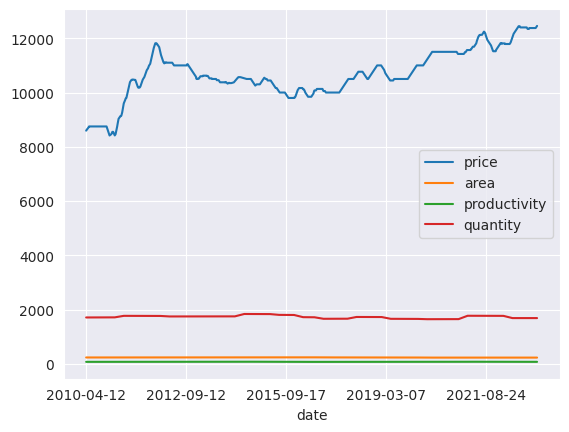

In [ ]:
df = df.rolling(45).mean()
df = df.dropna()
df.plot()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
nobs = 360
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(1894, 4)
(360, 4)


In [ ]:
df_train.to_csv("train_var_model.csv")
df_test.to_csv("test_var_model.csv")


In [ ]:
from google.colab import files
files.download('test_var_model.csv')
files.download('train_var_model.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Kiểm tra stationary

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1982
 No. Lags Chosen       = 9
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.2069. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "area" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3725
 No. Lags Chosen       = 1
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.5954. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "productivity" 
    -----------------------------------------------
 Null Hypothesis: Data ha

In [ ]:
df_differenced = df_train.diff().dropna()

In [ ]:
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6363
 No. Lags Chosen       = 8
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "area" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.5501
 No. Lags Chosen       = 0
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "productivity" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Leve

## Train model

In [ ]:
model = VAR(df_differenced)
for i in range(1, 50):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -29.97740709290218
BIC :  -29.918787750940112
FPE :  9.571445684163079e-14
HQIC:  -29.95582280648441 

Lag Order = 2
AIC :  -29.97946455814584
BIC :  -29.873904008980475
FPE :  9.551775288153794e-14
HQIC:  -29.94059496489282 

Lag Order = 3
AIC :  -29.968620923625956
BIC :  -29.81607845292818
FPE :  9.655920457169445e-14
HQIC:  -29.912450107231475 

Lag Order = 4
AIC :  -29.965341602759562
BIC :  -29.765776438656808
FPE :  9.687647718345144e-14
HQIC:  -29.891853623776832 

Lag Order = 5
AIC :  -29.94695386457394
BIC :  -29.700325177538314
FPE :  9.86744650523517e-14
HQIC:  -29.856132760369796 

Lag Order = 6
AIC :  -29.937325585402565
BIC :  -29.64359248813873
FPE :  9.962937106432004e-14
HQIC:  -29.829155370111586 

Lag Order = 7
AIC :  -29.92498409361012
BIC :  -29.584105640942873
FPE :  1.0086691729677174e-13
HQIC:  -29.7994487580886 

Lag Order = 8
AIC :  -29.912227997771108
BIC :  -29.52416318653268
FPE :  1.021622982137828e-13
HQIC:  -29.769311509550935 

Lag

In [ ]:
x = model.select_order(maxlags=50)
x.summary()

,AIC,BIC,FPE,HQIC
0,-18.36,-18.35,1.058e-08,-18.36
1,-29.89,-29.83*,1.048e-13,-29.86*
2,-29.89,-29.78,1.046e-13,-29.85
3,-29.88,-29.72,1.055e-13,-29.82
4,-29.88,-29.68,1.056e-13,-29.80
5,-29.86,-29.61,1.074e-13,-29.77
6,-29.85,-29.55,1.083e-13,-29.74
7,-29.84,-29.50,1.095e-13,-29.72
8,-29.83,-29.44,1.107e-13,-29.69
9,-29.82,-29.38,1.116e-13,-29.66


In [ ]:
model_var = model.fit(30)
model_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Jun, 2024
Time:                     04:00:57
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -28.1860
Nobs:                     1863.00    HQIC:                  -29.0933
Log likelihood:           17503.6    FPE:                1.36566e-13
AIC:                     -29.6227    Det(Omega_mle):     1.06176e-13
--------------------------------------------------------------------
Results for equation price
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.102843         0.093564            1.099           0.272
L1.price                 0.808586         0.023996           33.696           0.000
L1.area                398.675120       233.7492

In [ ]:
def adjust(val, length= 6): return str(val).ljust(length)

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_var.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

price  : 2.0
area   : 2.0
productivity : 2.0
quantity : 2.0


In [ ]:
# Get the lag order
lag_order = model_var.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

30


array([[ 0.        ,  0.02222222,  0.11555556,  2.81555556],
       [ 0.        ,  0.02222222,  0.11555556,  2.81555556],
       [ 0.        ,  0.02222222,  0.11555556,  2.81555556],
       [ 0.        ,  0.02222222,  0.11555556,  2.81555556],
       [ 0.        ,  0.02222222,  0.11555556,  2.81555556],
       [ 0.        ,  0.02222222,  0.11555556,  2.81555556],
       [ 0.        ,  0.02222222,  0.11555556,  2.81555556],
       [ 0.        ,  0.02222222,  0.11555556,  2.81555556],
       [ 0.        ,  0.02222222,  0.11555556,  2.81555556],
       [ 0.        ,  0.02222222,  0.11555556,  2.81555556],
       [ 0.        ,  0.02222222,  0.11555556,  2.81555556],
       [ 0.        ,  0.02222222,  0.11555556,  2.81555556],
       [ 0.        ,  0.02222222,  0.11555556,  2.81555556],
       [ 0.        ,  0.02222222,  0.11555556,  2.81555556],
       [ 0.        ,  0.02222222,  0.11555556,  2.81555556],
       [ 0.        ,  0.02222222,  0.11555556,  2.81555556],
       [ 0.        ,  0.

In [ ]:
import joblib
joblib.dump(model_var, 'var_gia_lua_nang_xuat.joblib')
from google.colab import files
files.download('var_gia_lua_nang_xuat.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('var_gia_lua_nang_xuat.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Forecast
nobs = len(df_test)
fc = model_var.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,price_2d,area_2d,productivity_2d,quantity_2d
date,,,,
2021-03-15,11.861113,0.021723,0.112989,2.753027
2021-03-16,11.597619,0.022264,0.110080,2.689936
2021-03-17,11.002546,0.022435,0.107446,2.630359
2021-03-18,11.167388,0.021905,0.103695,2.539524
2021-03-19,11.112087,0.021660,0.100986,2.475264
...,...,...,...,...
2022-12-19,1.631665,-0.001686,0.002748,0.051233
2022-12-20,1.631680,-0.001686,0.002748,0.051235
2022-12-23,1.631694,-0.001686,0.002748,0.051237


In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+ '_2d'].cumsum()
    return df_fc

In [ ]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)
df_results.loc[:, ['price_forecast']]

,price_forecast
date,
2021-03-15,11500.750002
2021-03-16,11512.347621
2021-03-17,11523.350167
2021-03-18,11534.517555
2021-03-19,11545.629641
...,...
2022-12-19,12336.076284
2022-12-20,12337.707963
2022-12-23,12339.339657


### Đánh giá mô hình VAR

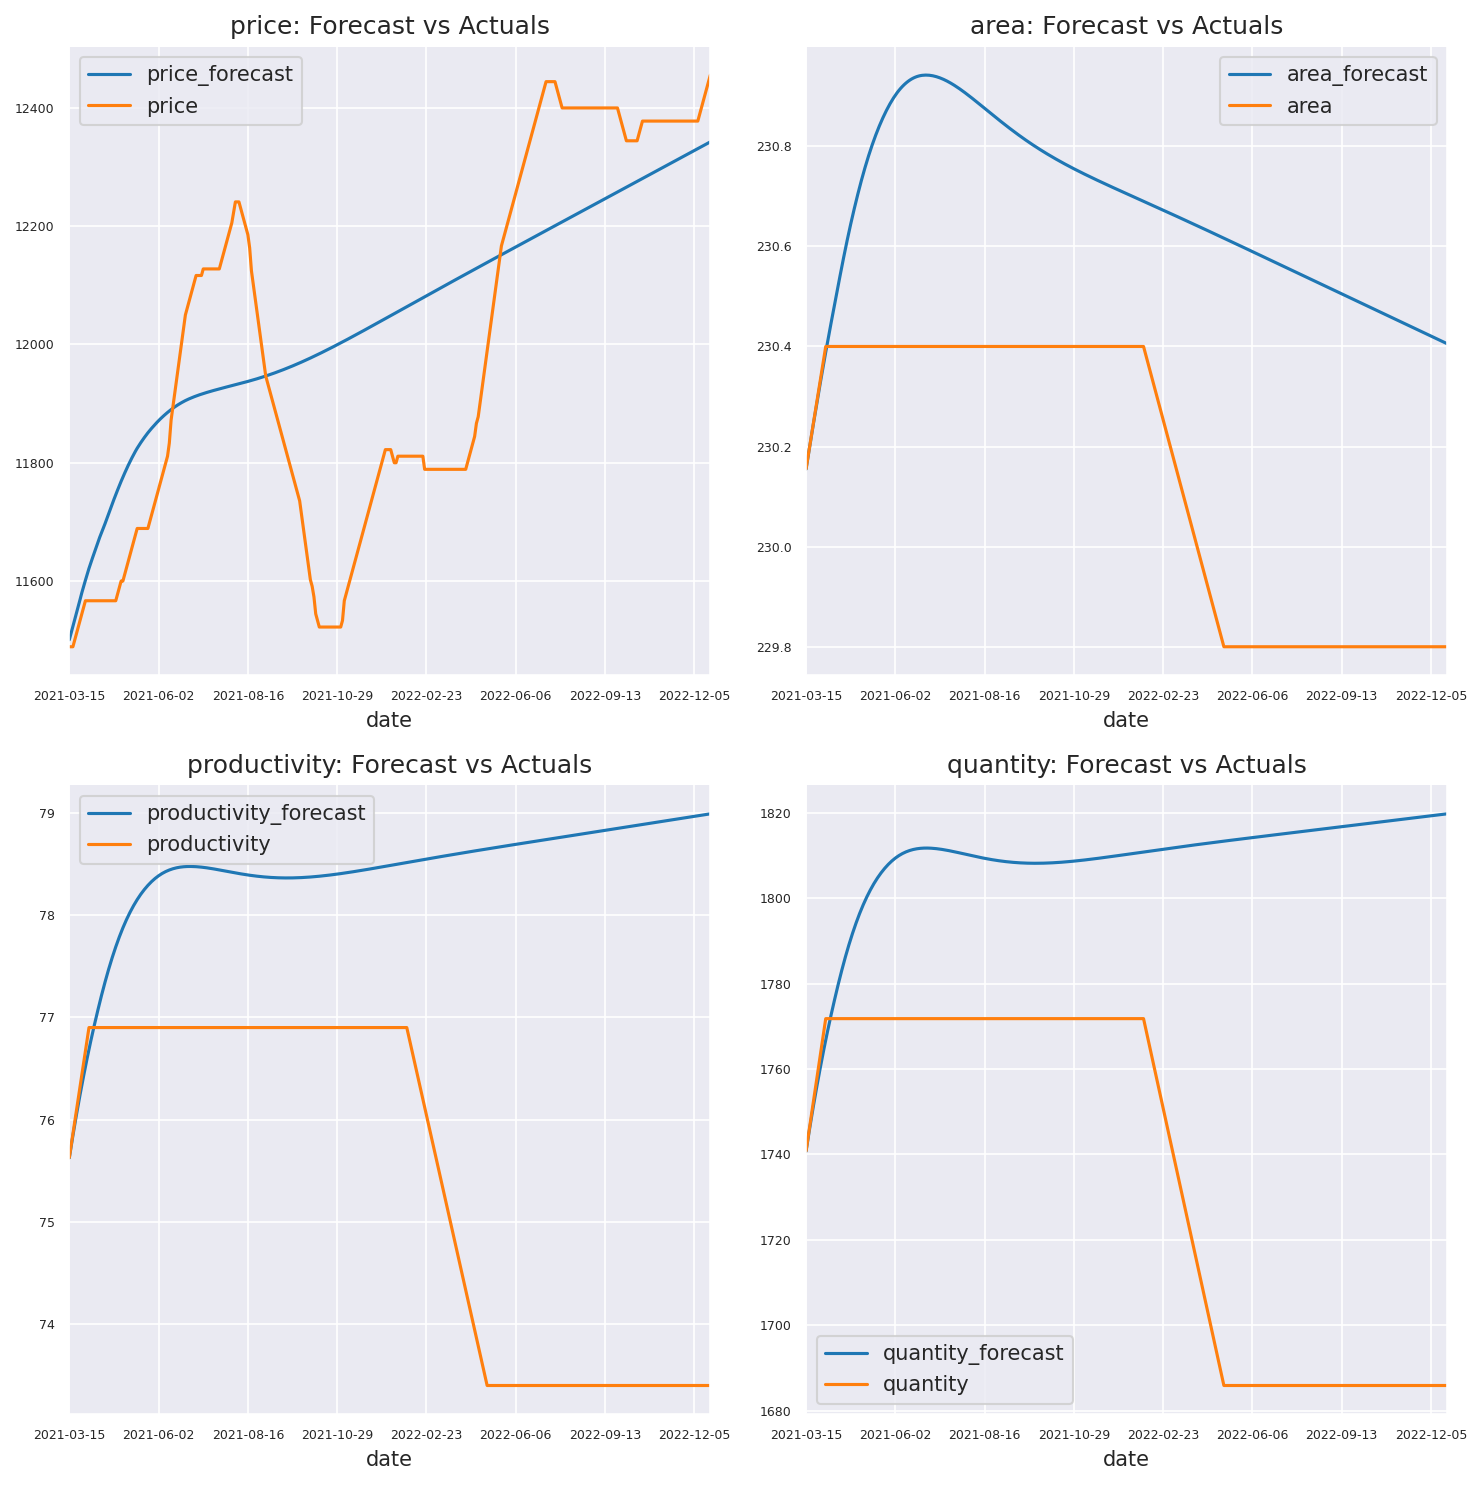

In [ ]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE

    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    return({'mape':mape,'rmse':rmse})

In [ ]:
print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape   :  0.0157
rmse   :  218.852


## VARMA Model

Mô hình Vector Autoregressive Moving Average (VARMA) là sự kết hợp của mô hình VAR và mô hình VMA, giúp trong việc mô hình hóa chuỗi thời gian đa biến bằng cách xem xét cả thứ tự của lag và thứ tự của trung bình di chuyển (p và q) trong mô hình.

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.0 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

In [ ]:
columns_train = ['price', 'area', 'productivity', 'quantity']

In [ ]:
pq = []
for name, column in df_differenced[columns_train].items():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(df_differenced[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : price
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=10616.243, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14449.787, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=10638.920, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12848.188, Time=0.44 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=10613.011, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=10614.603, Time=0.33 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=10614.223, Time=2.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=10614.119, Time=1.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=10616.264, Time=1.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=10615.053, Time=0.47 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=10615.711, Time=2.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=10613.598, Time=1.98 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 11.146 seconds
optimal order for:price is: (2, 0, 1

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics

In [ ]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [ ]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Open','RMSE High','RMSE Low','RMSE Close'])
print('Grid Search Started')
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(df_differenced[columns_train], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 30)
        inv_res = inverse_diff(df_train[columns_train], result)
        Opensrmse = np.sqrt(metrics.mean_squared_error(df_test['price'][:30], inv_res['price_forecast']))

        print(({'p': i[0], 'q': i[2], 'RMSE Open':Opensrmse}))


Grid Search Started
 Running for (2, 0, 1)
{'p': 2, 'q': 1, 'RMSE Open': 65.23274398728353}
 Running for (1, 0, 0)
{'p': 1, 'q': 0, 'RMSE Open': 138.6935119654111}
 Running for (1, 0, 0)
{'p': 1, 'q': 0, 'RMSE Open': 138.6935119654111}


In [ ]:
# from above example we can see that p=1 , q=2, tr=n gives least RMSE
model_varma = VARMAX(df_differenced[columns_train], order=(1,2),trends = 'n').fit( disp=False)
result = model_varma.forecast(steps = 360)

In [ ]:
inv_res = inverse_diff(df_train[columns_train], result)

Đánh giá mô hình

In [ ]:
accuracy_prod = forecast_accuracy(inv_res['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

mape   :  0.0569
rmse   :  769.8379


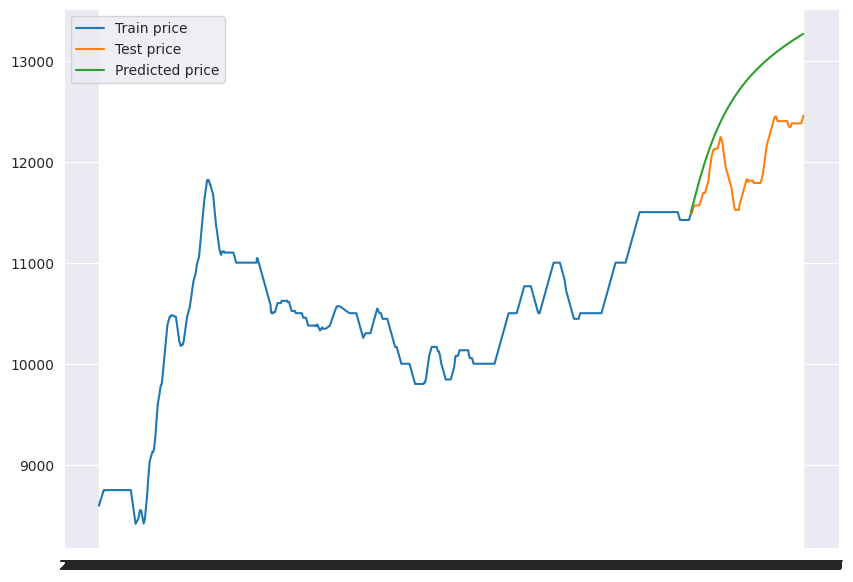

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['price']:

    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(df_train[str(i)], label='Train '+str(i))
    plt.plot(df_test[str(i)], label='Test '+str(i))
    plt.plot(inv_res[str(i)+'_forecast'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

In [ ]:
import joblib
from google.colab import drive

drive.mount('/content/drive')

var_file_name = 'var_gia_lua_nang_xuat.joblib'
varma_file_name = 'varma_gia_lua_nang_xuat.joblib'

joblib.dump(model_varma, '/content/drive/MyDrive/model/' + varma_file_name)


joblib.dump(model_var, '/content/drive/MyDrive/model/' + var_file_name)

Mounted at /content/drive


['/content/drive/MyDrive/model/var_gia_lua_nang_xuat.joblib']